# Code Availability
This code is written in Python (3.6>) and publicly available. The aim is to provide a custom code to process, visualize and manipulate the SandBoxNL dataset. This statement is included under the heading "Code availability" of the publication: "Sentinel-1 SAR based parcel level crop data in The Netherlands". [Vineet Kumar, Manuel Huber, Bjorn Rommen, and Susan C. Steele-Dunne]

Support:
In the case of any issues or inquiries please contact either:

Vineet Kumar (TU Delft, V.Kumar-1@tudelft.nl), 
Manuel Huber (ESA, ESTEC, manuel.huber@esa.int), 
Susan Steele-Dunne (TU Delft, s.c.steele-dunne@tudelft.nl), 
Björn Rommen (ESA, ESTEC, Bjorn.Rommen@esa.int)

# Abstract and Context: SandBoxNL
Synthetic aperture radar (SAR) data processing, handling and understanding poses significant challenges to both agricultural application specialist and non-expert domain users in the field of agricultural monitoring. Additionally, the data volume of openly available Sentinel-1 SAR requires high-performance local computational facilities to the expert users in operational applications using dense time series of data. To overcome these complexities, we have generated an annual Sentinel-1 SAR database that includes mean and standard deviation of VV, VH and VH/VV backscatter, pixel counts, geometry, crop type, local incidence angle and azimuth angle at parcel-level. The database uses around 1200 Sentinel-1  images to provide time series for approximately 770,000 crop parcels over the Netherlands annually. The database can be queried for Sentinel-1 system parameter (e.g. relative orbit) or user application-specific parameter (e.g. crop type, spatial extent, time period) for individual parcel level assessment or aggregated at administrative boundaries. The database may potentially be useful for agricultural and water related applications in the Netherlands, such as parcel-level crop bio-geophysical parameter estimation, change-detection, inter-annual variability analysis, drought monitoring, grassland monitoring and administrative boundaries based agricultural management decisions.

# Introduction: SandBoxNL Dataset - Coherence
The annual database consists of spatially averaged VV, VH coherence data and corresponding standard deviation for each parcel. Every crop parcel has a unique field ID (OBJECTID), which is used as an index to sort, process and clean the data. Each parcel is stored separately in a data frame containing the time series of all the above-mentioned extracted parameters. Static information about the parcel geometry and crop type is not saved in the netCDF file. The dataset are provided per province and annually.

The following code gives a brief example of how to access, manipulate and visualize the netCDF dataset with Flevoland (2019).

In [1]:
"""
 -*- coding: utf-8 -*-
Created on Tue Apr  6 16:05:00 2021
@author: Manuel Huber (ESA, ESTEC: manuel.huber@esa.int)
"""

import netCDF4 as nc4
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import pickle
from datetime import datetime, date, time
import glob
import math    
import os
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [6]:
# Reading the data.... 
# Example for one province in 2018

# Path of netCDF datasets (per province)
path = 'C:/Users/Manuel Huber/Documents/Publication SandboxNL/GEEoutput_Coherence/'

# Selecting one province as example... 
fh = Dataset('{}Coherence_2019.nc'.format(path), mode='r')

# Selecting and loading PDOK shp files for geometry and crop description...
fields = gpd.read_file('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/SandBoxNL/SandboxNL/April_2020/BRP_2019_proj/BRP_Proj_2019.shp') 

# Find crop types from BRP parcel name list.
The Basisregestratie GewasPercelen (BRP, Base Crop Parcel Register) shape filescontains parcel name information in Dutch. To extract the information about theparticular parcel or crop type user needs to input/query the database in Dutch. Hence to assist crop type information, we have provided the following list detailsthe corresponding crop name in English  ("BRP_Parcel_Name_list_dutsch_english_2019") . 

User needs to input exact name of crop in Dutch language including the special characters (Example: Aardappelen, bestrijdingsmaatregel AM). These following list is created by using BRP 2019 data. Specifically Maize crop has a special character in the BRP-2019 shape files,(Ma�s, snij-). So, user should carefully input while calling 2019 maize cropdatabase. For 2017 and 2018 Maize crop can be called with actual Dutchword (Maïs) for it.

The following code should help to select the correct dutch crop names. Two functions are implemented to either find the corresponding names using either a english crop name or starting letter. In total 312 different crops are prese

In [ ]:
# Loading the excel sheet, which contains the dutch and english description of the crop types
translate = pd.read_excel('C:/Users/Manuel Huber/Documents/FInal Datasets SandboxNL/Translation_List_Dutch_English_Crop_Names_2019.xlsx')
translate.index = translate['Crop_Number'].astype(int)  # The crop number refers to the 'GWS_GEWASC' number of the BRP/Fields files
del translate['Crop_Number']

# Function to find all descriptive names (dutch and englisch) for a given crop name/type (given in englisch)
def find_crop_names_per_name(mystring):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if mystring in cell:
            index.append(i)
    return translate.iloc[index]

# Function to find crops with starting letter of the crop name/type (serach in english)
def find_crop_names_per_letter(myletter):
    index = []
    for i in range(len(translate)):
        cell = translate['Crop name (English)'].iloc[i]
        if myletter in cell[0]:
            index.append(i)
    return translate.iloc[index]

# Two examples on how to use the above functions:
example1 = find_crop_names_per_name("Potatoes") # Input must be in english. Sometimes 
                                                # Crops are given in plural or small/big captial starting letter
                                                # If this does not help please search manually in the trasnlation list
print('Output for search using an english name:','\n',example1)


# If it is not possible to find the crop using the full name try to search for the starting letter:
example2 = find_crop_names_per_letter("W") # Input must be in in engish and capital (sometimes large or small)
print('Output for search using a letter:','\n',example2)


In [7]:
# Getting list of variables stored in the netCDF

# Keys for time variable data (Parcel x Time)
keys_data = list(fh['Data'].variables.keys())
# Keys for static data (Parcel)
keys_ID = list(fh['Parcel_ID'].variables.keys())

print('Variables:' ,'\n', keys_data)
print('Static Information per ID:' ,'\n',keys_ID)


Variables: 
 ['vv_mean', 'vv_std', 'vh_mean', 'vh_std', 'OID', 'pix', 'MID', 'RO', 'time_num']
Static Information per ID: 
 ['ID', 'lon', 'lat']


# Selecting ObjectIDs and field information depending on longitude and latitude

This is necessary for users, who have a list of longitudes and latitudes and want to select the fields according to those. This can be done using the fields polygons (provided by PDOK). The polygons are selected on the bases that the lon-lat combination (point) is within the outlined polygon. This means that the points must be in the boundary of the parcel in order to be identified. Again, it is to mention that the field locations change per year, which makes it important to always select the correct shapefile. Furthermore, it is important to have loaded the correct netCDF file to match the objectIDs.  

In the following example, points where selected in the Flevoland province.


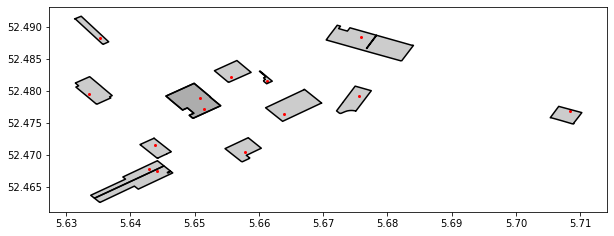

In [8]:
# List of points (this can be integrated by uploading a csv file - in case a lat-lon list exists already)
list_lon_lat = [
    [5.675902485185551,52.48838138537458],
    [5.663843273454594,52.47630669355332],
    [5.655646442705082,52.482083095990625],
    [5.70838940077393,52.476829476115576],
    [5.675602077775883,52.47918192078341],
    [5.651483654313969,52.47722155896118],
    [5.657878040605473,52.470477247257],
    [5.643801807695317,52.47157522890128],
    [5.661268352800297,52.48156037584885],
    [5.650754093461918,52.47884213099183],
    [5.635304569536137,52.48827685681074],
    [5.633502125078129,52.47949557056959],
    [5.642943500810551,52.467889039283634],
    [5.644059299760746,52.46754916228505]
    ]
# Create a geocoded points
df_points = [Point(list_lon_lat[i][0], list_lon_lat[i][1]) for i in range(len(list_lon_lat))]

# Function to extract the polygon for each field in the list
def get_id_per_lon_lat(list_lon_lat, fields):
    ls_points = []
    for i in range(len(list_lon_lat)):                   
        point = Point(list_lon_lat[i][0], list_lon_lat[i][1])
        ls_points.append(fields[fields.geometry.contains(point)])
    return pd.concat(ls_points)

lst_polygons = get_id_per_lon_lat(list_lon_lat, fields) # Apply function *fields = PDOK shapefile
selected_poly  = lst_polygons[lst_polygons.OBJECTID.isin(fh['Parcel_ID']['ID'][:].data)] # Check if the selected fields are in the netCDF dataset
# Plotting the selected parcels for the given points
fig,ax= plt.subplots(figsize=(10,4))
gpd.GeoDataFrame(selected_poly, geometry='geometry').plot(ax =ax, color='grey', alpha = 0.4,  missing_kwds={"edgecolor": "red"}) # Corresponding polygons
gpd.GeoDataFrame(selected_poly, geometry='geometry').boundary.plot(ax =ax, markersize=2, color='black')
gpd.GeoDataFrame(df_points, geometry=df_points).plot(ax =ax, markersize=4,color= 'red') # Points selected by user

selected_IDs = selected_poly.OBJECTID # This gives a list OBJECTIDs corresponding to the selected fields.

# Structuring the data
Data can be directly used from the netCDF file. However, due to data handling I recommend using pandas or similiar dataframe libaries to further process the data. In this example pandas is used.
 
The structure of the netCDF is per ObjectIDs for example:

fh['Data']['vv_mean'][:,:].data - Gives the VV (mean) coherence for all parcels and time [Parcel:Time]
fh['Parcel_ID']['ID'][:].data  - Gvies the ObjectIDs of all parcels

In [9]:
# Load static data in a pandas dataframe per field ID:

df_ID = pd.DataFrame()
for i in range(len(keys_ID)):
    df_ID['{}'.format(keys_ID[i])] = fh['Parcel_ID'][keys_ID[i]][:].data 

# Combine static information with field information to one dataframe
fields.index = fields.OBJECTID.astype(int)
df_ID.index = df_ID.ID
fields_sel = fields[fields.index.isin(df_ID.index)] # Select only field IDs which are represented in the loaded data


df_ID = pd.concat([df_ID,fields_sel],axis=1) # Combine field information with static parcel information into one dataframe

print(df_ID.info(), df_ID.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 1526174 to 2298696
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          9555 non-null   int32   
 1   lon         9555 non-null   float32 
 2   lat         9555 non-null   float32 
 3   OBJECTID    9555 non-null   int64   
 4   CAT_GEWASC  9555 non-null   object  
 5   GWS_GEWASC  9555 non-null   object  
 6   GEOMETRIE_  9555 non-null   float64 
 7   GEOMETRIE1  9555 non-null   float64 
 8   GWS_GEWAS   9555 non-null   object  
 9   geometry    9555 non-null   geometry
dtypes: float32(2), float64(2), geometry(1), int32(1), int64(1), object(3)
memory usage: 709.2+ KB
None               ID       lon        lat  OBJECTID CAT_GEWASC GWS_GEWASC  \
1526174  1526174  5.454935  52.280251   1526174   Grasland        265   
1526175  1526175  5.461063  52.274021   1526175   Grasland        266   
1526176  1526176  5.458593  52.280800   1526176   Graslan

In [10]:
# Function to extract time series data per variable and per parcel.

def get_data_from_netcdf(netCDF, key):
    data_all = netCDF['Data']['{}'.format(key)][:,:].data # Key is the selected variable
    mask = netCDF['Data']['{}'.format(key)][:,:].mask
    data_mask =[]
    for i in range(len(data_all)):
        data_mask.append(data_all[i][~mask[i]])        

    return data_mask
    

In [11]:
# Function to transform the time 
def transform_time(data):
    calendar = 'gregorian' # Time is transfromed to gregorian time in the netCDF 
    units = 'hours since 1900-01-01 00:00:00.0'
    
    time = [pd.to_datetime(nc4.num2date(data.iloc[ls], units = units, calendar = calendar).astype(str), format='%Y-%m-%d %H:%M:%S') for ls in range(len(data))]
    return time

In [12]:
# Load time series data:
      
keys_data = ['vv_mean', 'vh_mean','RO','time_num']  # Selection of variables for further analysis

df_data = pd.DataFrame() # Creating a dataframe at which all variables of a unique parcel will be stored.

for i in range(len(keys_data)):
    df_data['{}'.format(keys_data[i])]=get_data_from_netcdf(fh, keys_data[i])    

df_data.index = df_ID.ID # Put ObjectIDs as index 

# Transform the gregorian time to the actually time stamps
date_time = pd.DataFrame(transform_time(df_data.time_num))
date_time.index = df_data.index

print(df_data.head())

                                                   vv_mean  \
ID                                                           
1526174  [0.49116942, 0.41217998, 0.41112563, 0.3709911...   
1526175  [0.31534234, 0.31424397, 0.4410939, 0.24708813...   
1526176  [0.32471347, 0.27087694, 0.4521945, 0.26879674...   
1526864  [0.23721036, 0.7834449, 0.2976646, 0.71907425,...   
1526865  [0.78293747, 0.39104557, 0.2681522, 0.70101714...   

                                                   vh_mean  \
ID                                                           
1526174  [0.16901036, 0.27395007, 0.2859342, 0.2557303,...   
1526175  [0.31489757, 0.27661058, 0.31976554, 0.2523391...   
1526176  [0.30972925, 0.33686414, 0.3928234, 0.28802007...   
1526864  [0.2152202, 0.48568907, 0.30196437, 0.2189186,...   
1526865  [0.46488053, 0.3084761, 0.24040008, 0.27143142...   

                                                        RO  \
ID                                                           
152617

In [13]:
# Get the units and describtions: 
    
units = []
descrp = []

for i in range(len(keys_data)):
    units.append(fh['Data']['{}'.format(keys_data[i])].unit)
    descrp.append(fh['Data']['{}'.format(keys_data[i])].long_name)
    
    
print('Units' +'\n',units)
print('Descriptions' +'\n',descrp)

Units
 ['[-]', '[-]', '[-]', 'hours since 1900-01-01 00:00:00.0']
Descriptions
 ['Coherence - VV mean - 0', 'Coherence - VH mean - 2', 'Relavtive Orbit - 7', '[calendar = gregorian; units = hours since 1900-01-01 00:00:00.0]']


# Plotting time series for an example field

Here the static information can be used to select specific parcels. For example, certain crop types and specific lon and lat etc. 


             vv_mean   vh_mean   RO
1526174                            
2019-04-02  0.491169  0.169010  110
2019-04-08  0.523631  0.170194  110
2019-04-14  0.394371  0.219654  110
2019-04-20  0.460404  0.272142  110
2019-04-26  0.471629  0.475843  110


Text(0.5, 1.0, '1526174 - Orbit 110')

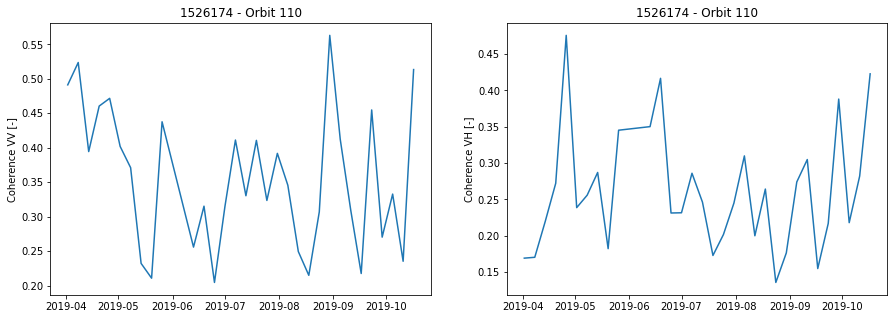

In [16]:
# First Plotting time series.... Comparing backscatter signal from all orbits to one orbit:
'''
Variables: 
 ['vv_mean', 'vv_std', 'vh_mean', 'vh_std', 'OID', 'pix', 'MID', 'RO', 'time_num']
These can be used as a vector or directly as a string.

'''

# Example selection of the first field in the dataframe
field = 0  

df_plot = pd.DataFrame()
for i in range(len(keys_data)-1):
    df_plot[keys_data[i]] = df_data[keys_data[i]].iloc[field]
df_plot.index =   date_time.iloc[field].dropna()                    
df_plot = df_plot.sort_index()
print(df_plot.head())


# Plotting vv mean backscatter
var_VV = df_plot[keys_data[0]] # Selection of variable and transfromation the signal to dB
var_VH = df_plot[keys_data[1]] # Selection of variable and transfromation the signal to dB


fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(df_plot.index, var_VV)
plt.ylabel('Coherence VV [-]')
plt.title('{} - Orbit 110'.format(df_ID['ID'].iloc[field]))

plt.subplot(1,2,2)
plt.plot(df_plot.index, var_VH)
plt.ylabel('Coherence VH [-]')
plt.title('{} - Orbit 110'.format(df_ID['ID'].iloc[field]))



# Plotting time series for a certain crop type

In [17]:
# Plotting certain crop type variation

# 1) Get list of all crop types

list_crops = df_ID[df_ID['GWS_GEWAS']]
print(list_crops.head())

# 2) Get Object IDs for certain crop type using field data (PDOK)) 

crop_string = 'Aardappelen, consumptie' # One example from all crop types
crop = df_ID[df_ID['GWS_GEWAS']==crop_string] 

print(crop_string, ' - Length Parcels: ', len(crop))

Aardappelen, consumptie  - Length Parcels:  928


In [18]:
# 2) Selecting data depending on the crop object IDs and orbit

# List of ObjectIDs
IDs = crop.index


data_crop = df_data[df_data.index.isin(IDs)]
date_time_crop = date_time[date_time.index.isin(IDs)]

df_crop = []

for field in range(len(IDs)):
    df_plot = pd.DataFrame()

    for i in range(len(keys_data)-1): # For all variables...
        df_plot[keys_data[i]] = data_crop[keys_data[i]].iloc[field]
    df_plot.index =   date_time_crop.iloc[field].dropna()  
    df_crop.append(df_plot)


print(df_crop[0].head())

             vv_mean   vh_mean   RO
1526865                            
2019-04-02  0.782937  0.464881  110
2019-09-05  0.391046  0.308476  110
2019-07-07  0.268152  0.240400  110
2019-05-08  0.701017  0.271431  110
2019-10-11  0.704668  0.485299  110


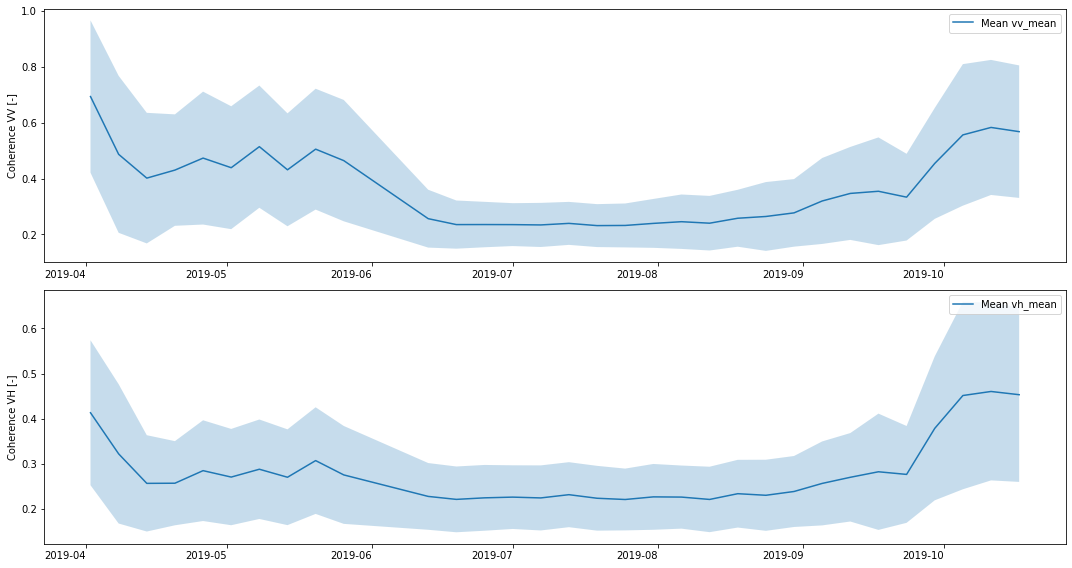

In [21]:
# 3) Plotting mean and variation for crop in province (Considering one Orbit)

# Function to calculate mean and std per field in a object ID selection
def get_std_mean_for_var(data, var):
    data_db = pd.concat(data, axis=1)
    data_db = data_db[var]
    mean = data_db.T.mean()
    std = data_db.T.std()
    return [mean, std]

vv = get_std_mean_for_var(df_crop, 'vv_mean')
vh = get_std_mean_for_var(df_crop,'vh_mean')

fig,ax= plt.subplots(figsize=(15,8))

plt.subplot(2,1,1)
var = vv
ax = var[0].plot(label = 'Mean {}'.format(keys_data[0]))
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel('Coherence VV [-]')
plt.legend()

plt.subplot(2,1,2)
var = vh
ax = var[0].plot(label = 'Mean {}'.format(keys_data[1]))
ax.fill_between(var[0].index,  var[0] -  var[1],  var[0] +  var[1],
                alpha=.25)
ax.tick_params(axis='x', labelrotation=0 )
ax.set_ylabel('Coherence VH [-]')
plt.legend()

plt.tight_layout()

# Plotting spatial plots for a specific time step

In the fields (shapefile) the geometries are available to plot the field outlines. Filling these fields with colormaps depending on certain variables gives a good illustration of the spatial value distribution for a certain time step. 

In [23]:
# Get date and create dateframe per time step for all fields
time_uni =np.unique(date_time.dropna().astype(str))
print('Length unique timesteps: ', len(time_uni))
# Example time step
dates = pd.to_datetime(time_uni).date
time_sel = dates[10] # Select random date as an example 
time_sel 

geo_df = []
IDs_sel = []


for field in range(len(df_ID)):
    df_plot = pd.DataFrame()

    for i in range(len(keys_data)-1): # For all variables...
        df_plot[keys_data[i]] = df_data[keys_data[i]].iloc[field]
    df_plot.index =  date_time.iloc[field].dropna()
    df_plot = df_plot[df_plot.index.date == time_sel]
    if len(df_plot)!= 0:
        geo_df.append(df_plot)
        IDs_sel.append(df_ID.index[field])
geo_df = pd.concat(geo_df)
geo_df.index = IDs_sel


print(geo_df.head())

Length unique timesteps:  32
          vv_mean   vh_mean   RO
1526174  0.255762  0.350138  110
1526175  0.283280  0.303838  110
1526176  0.276299  0.289970  110
1526864  0.368535  0.264817  110
1526865  0.443837  0.260685  110


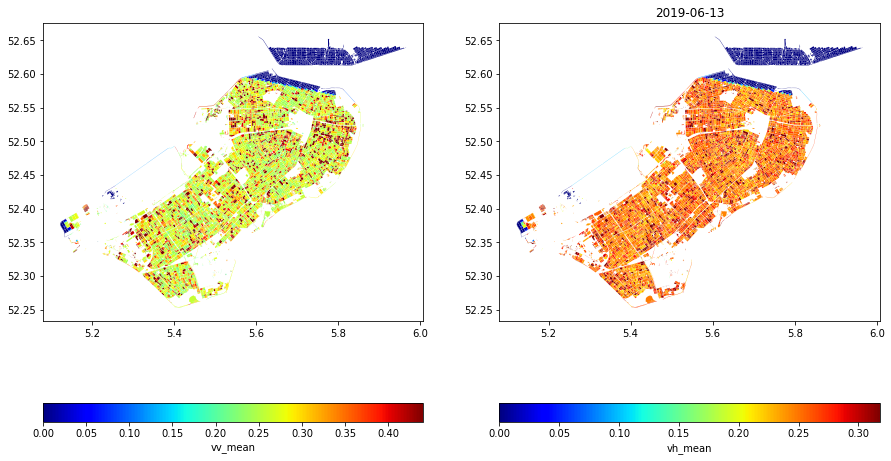

In [25]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))

geo_plot = gpd.GeoDataFrame(df_ID[df_ID.index.isin(geo_df.index)], geometry='geometry')   # Create geopandas dataframe for the selected object IDs
#Plotting all three variables... 
var =['vv_mean', 'vh_mean']
axes =[ax1, ax2]
for i in range(len(var)): # Plotting it for VV and VH backscatter
        geo_plot[var[i]]= geo_df[var[i]].values # Transforming the backscatter into dB
        gpd.GeoDataFrame(geo_plot, geometry='geometry').plot(ax =axes[i],column = var[i], cmap ='jet', legend=True, vmin =np.percentile(geo_plot[var[i]],10), vmax =np.percentile(geo_plot[var[i]],90),legend_kwds={'label': var[i], 'orientation': "horizontal"})
        plt.title(time_sel)